# A Toy Metabolic Network

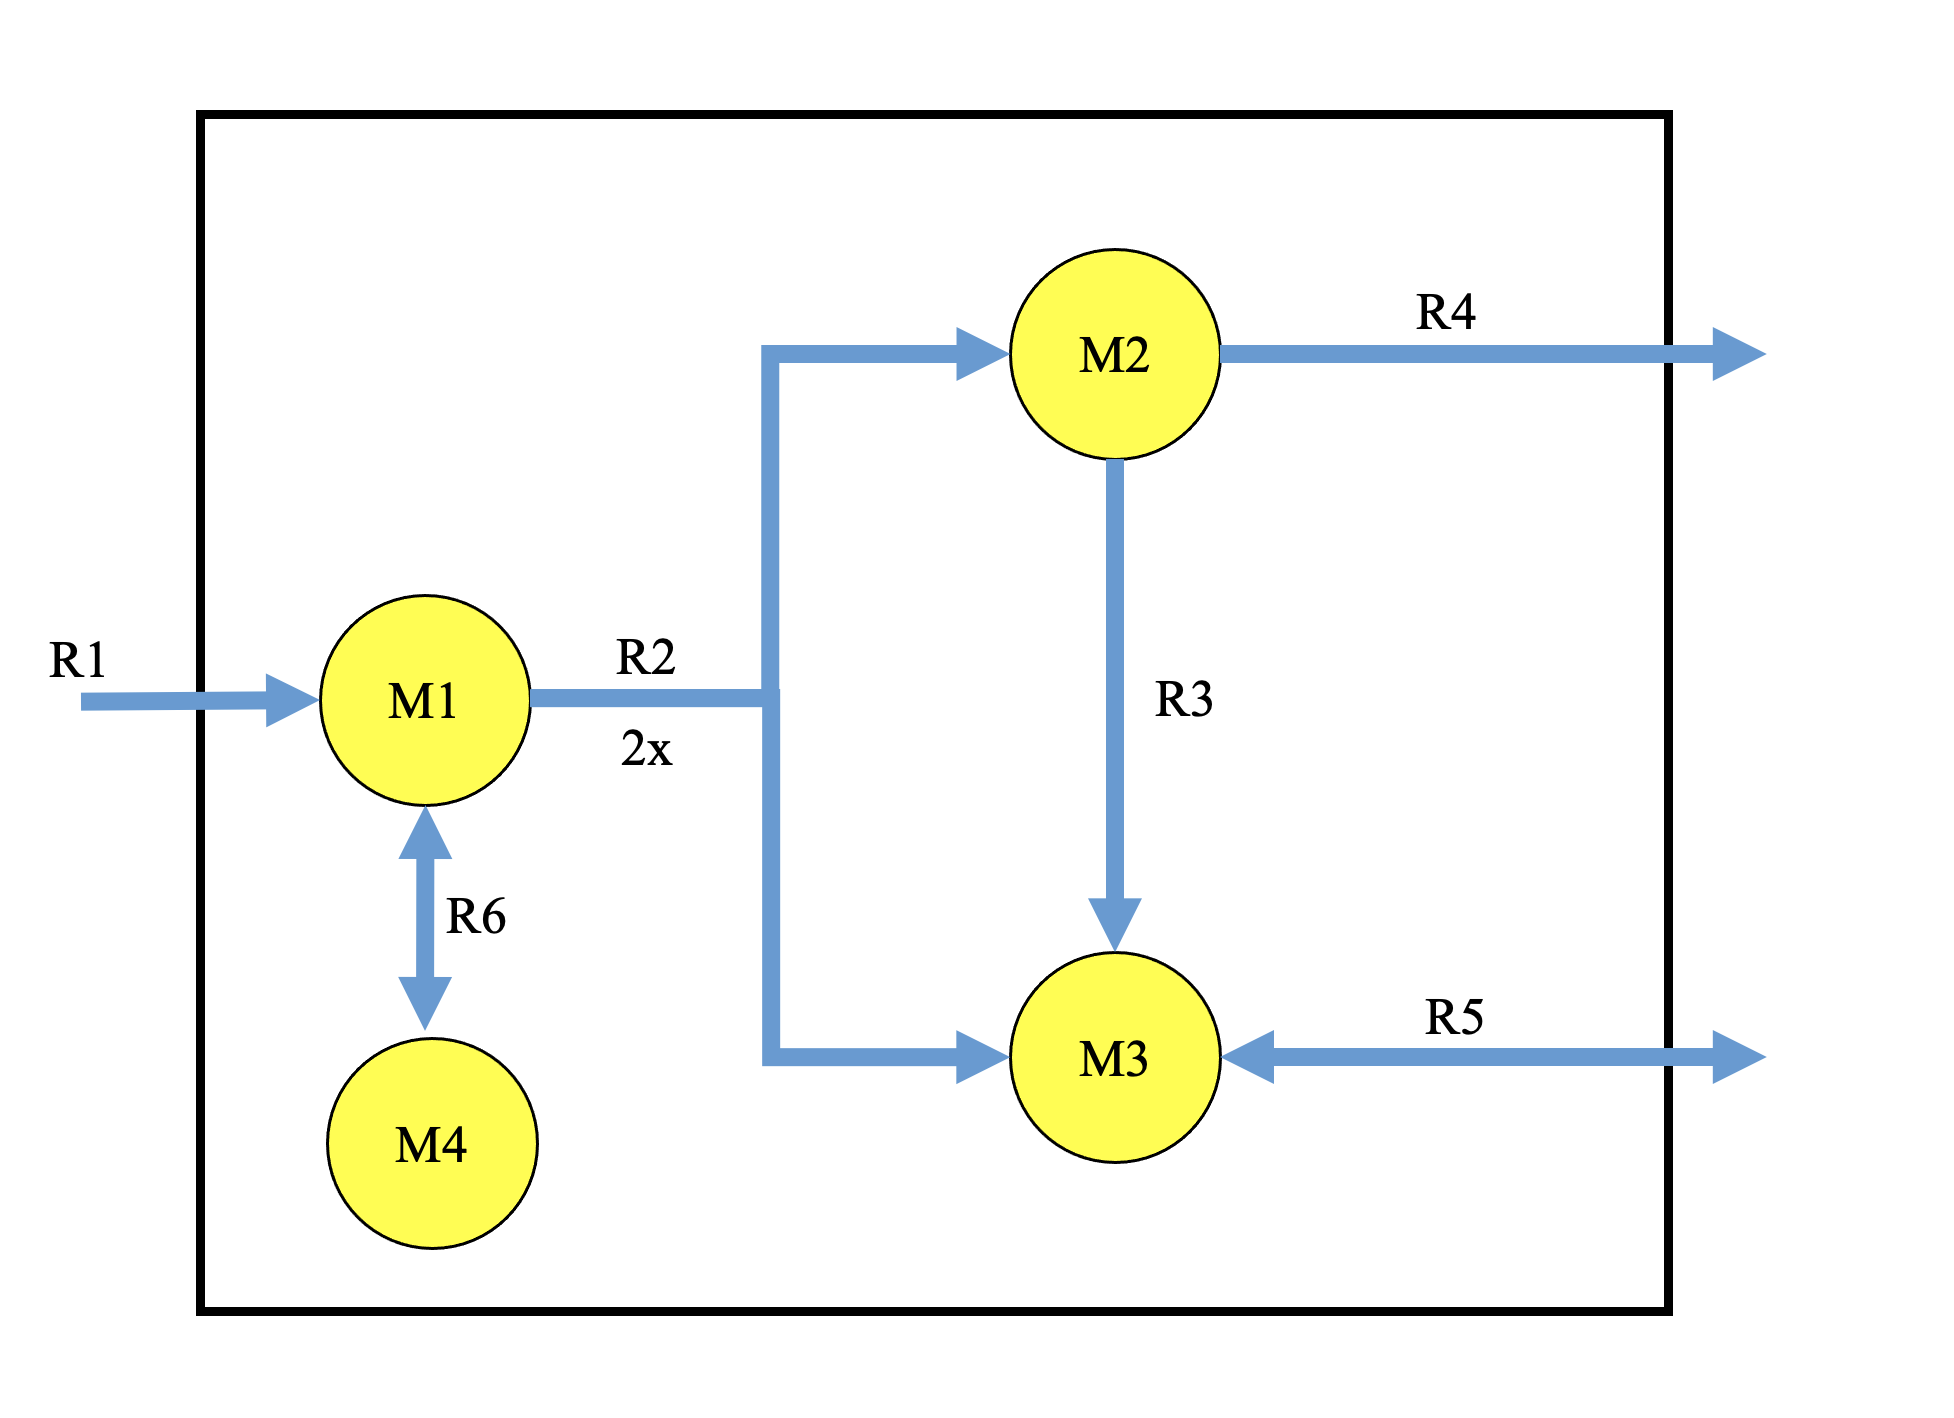

# Add worker processes and Import Packages 

In [1]:
using Distributed

# Add worker processes to the Julia distributed computing environment:
addprocs(7)
println("Number of Workers : $(nprocs())")

## Import Libraries

# A Toolkit of Functions for Preprocessing Metabolic Network Data:
include("../src/Data Processing/pre_processing.jl")

# Identifying Blocked Reactions in a Metabolic Model using Convex Optimization(n_i + 2n_r LP):
include("../src/Consistency Checking/TheNaiveApproach.jl")

# Identifying blocked reactions in metabolic networks using Convex Optimization(1LP) and Gaussian Elimination:
@everywhere include("../src/Consistency Checking/SwiftCC.jl")

# Parallel computation of quantitative flux coupling using swiftCC algorithm and Gaussian Elimination:
@everywhere include("../src/QFCA/distributedQFCA.jl")

# Import required Julia modules:
using .pre_processing, .TheNaiveApproach, .SwiftCC, .DistributedQFCA, COBREXA, JuMP, sparseQFCA


Number of Workers : 8


## Reconstruct a TestModel

In [2]:
model = StandardModel("TestModel") 
gene_list = [Gene(string("g", num)) for num = 1:6]
add_genes!(model, gene_list)
metabolite_list = [Metabolite(string("M", num)) for num = 1:4]
println()

## Reactions:

#### Exchange M1
#### M1 $\rightarrow$M2 + M3
#### M2 $\rightarrow$ M3
#### Exchange M2
#### Exchange M3
#### M1 $\rightarrow$ M4

In [3]:
add_metabolites!(model, metabolite_list)
R1 = Reaction("R1", Dict("M1" => 1.0), :forward)
R2 = Reaction("R2", Dict("M1" => -2.0, "M2" => 1.0,  "M3" => 1.0), :forward)
R3 = Reaction("R3", Dict("M2" => -1.0, "M3" => 1.0), :forward)
R4 = Reaction("R4", Dict("M2" => -1.0), :forward)
R5 = Reaction("R5", Dict("M3" => 1.0), :reverse)
R6 = Reaction("R6", Dict("M1" => -1.0, "M4" => 1.0), :reverse)

add_reactions!(model, [R1, R2, R3, R4, R5, R6])

# Flux Coupling Analysis (FCA)


For each pairs of reactions, $j_1$ and $j_2$, five possible coupling cases is imaginable:


0. Uncoupled: $R_{min} = 0, R_{max} = \infty$
1. Fully Coupled ($v_i \Leftrightarrow v_j$): $R_{min} = R_{max} = c > 0$ , $[v_i = c v_j,\quad\forall v \in \mathcal{C}]$ 
2. Partially Coupled ($v_i \leftrightarrow v_j$): $R_{min} = c_1 > 0, R_{max} = c_2 > 0$ , $[v_i \neq 0 \Leftrightarrow v_j \neq 0,\quad\forall v \in \mathcal{C}]$
3. Directionally Coupled ($v_i \rightarrow v_j$): $R_{min} = 0, R_{max} = c > 0$ , $[v_i \neq 0 \Rightarrow v_j \neq 0,\quad\forall v \in \mathcal{C}]$
4. Directionally Coupled ($v_i \leftarrow v_j$): $R_{min} = c > 0, R_{max} = \infty$ , $v_j \neq 0 \Rightarrow v_i \neq 0,\quad\forall v \in \mathcal{C}$

# distributedQFCA

The function takes a metabolic model as input and calculates directional couplings and coefficients for each pair of reactions in the model. It also has the option to remove reactions from the model and recalculate the couplings. The function uses parallel processing to distribute the calculations across multiple processors. The output is a matrix that shows the coupling relations between the reactions in the model.

- `fctable`:
    The resulting flux coupling matrix.
    The meaning of the entry (i, j) is:
    * 0 - uncoupled reactions
    * 1 - fully coupled reactions
    * 2 - partially coupled reactions
    * 3 - reaction i is directionally coupled to reaction j
    * 4 - reaction j is directionally coupled to reaction i

- `Fc_Coefficients`:           
    A list of fully-coupling coefficients. 

- `Dc_Coefficients`:          
    A list of DCE (directional coupling equation) coefficients.

In [4]:
fctable, Fc_Coefficients, Dc_Coefficients = distributedQFCA(model)
println()

Number of Metabolites : 4
Number of Reactions   : 6
Number of Genes       : 6
Stoichiometric matrix : 4 x 6
Number of irreversible reactions : 4 
Number of reversibe    reactions : 2 
Homogenization:
M = 1.0e6
Consistency_Checking(SwiftCC):
Tolerance = 1.0e-6
Number of irreversible blocked reactions : 0
Number of reversible   blocked reactions : 1
Number of blocked reactions              : 1
Reversibility Correction:
Tolerance = 1.0e-6
Number of reversibe blocked in forward  direction : 1
Number of reversibe blocked in backward direction : 0
Number of irreversible reactions after Correction : 5
Number of reversible   reactions after Correction : 0
Quantitative Flux Coupling Analysis(distributedQFCA):
Final fctable : 
Number of 0's (unCoupled) : 2
Number of 1's (Fully)     : 7
Number of 2's (Partialy)  : 4
Number of 3's (DC i-->j)  : 6
Number of 4's (DC j-->i)  : 6



## Flux Coupling Table

In [5]:
println("fctable : ")
display(fctable)

fctable : 


5×5 SharedArrays.SharedMatrix{Int64}:
 1  1  4  4  2
 1  1  4  4  2
 3  3  1  0  3
 3  3  0  1  3
 2  2  4  4  1

## FC_Coefficients

In [6]:
println("FC_Coefficients : ")
display(Fc_Coefficients)

FC_Coefficients : 


5×5 SharedArrays.SharedMatrix{Float64}:
 1.0  2.0  0.0  0.0  0.0
 0.5  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0

$v_{1} = 2v_{2}$
\
$0.5v_{1} = v_{2}$

# Quantitative Flux Coupling Analysis (QFCA)

**DCE Theorem:** In a network without any irreversible blocked reaction, for an arbitrary reaction $R_j$, if $D_j$ is the non-empty set of all the irreversible reactions directionally coupled to $R_j$ (excluding itself), there exists positive coefficients $\{c_d\}_{d: R_d \in D_j}$ such that:

$$
v_j = \sum_{d: R_d \in D_j} c_d v_d
$$ 

 ## DC_Coefficients

In [7]:
println("DC_Coefficients : ")
display(Dc_Coefficients)

DC_Coefficients : 


5×5 SharedArrays.SharedMatrix{Float64}:
  2.0  -1.0  -1.0  -2.0  -1.0
 -1.0   5.0  -1.0  -2.0  -1.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
 -1.0  -1.0  -5.0  -1.0   4.0

$2v_{1} = v_{2} + v_{3} + 2v_{4} + v_{5}$
\
$5v_{2} = v_{1} + v_{3} + 2v_{4} + v_{5}$
\
$4v_{5} = v_{1} + v_{2} + 5v_{3} + v_{4}$

## Mass Balances

#### M1:
$v_{1} = 2v_{2}$

#### M2:
$v_{2} = v_{3} + v_{4}$

#### M3:
$v_{2} + v_{3} = v_{5}$

## Extended DCEs

 


#### DCE_1:
$v_{1} = v_{4} + v_{5}$$\rightarrow$$2v_{2} = v_{4} + v_{5}$

#### DCE_2(M1,M2):
1.$v_{1} = 2v_{2}$
\
2.$v_{2} = v_{3} + v_{4}$
\
1,2$\rightarrow$$0.5v_{1} = v_{3} + v_{4}$

#### DCE_3(M1,M3):
1.$v_{1} = 2v_{2}$
\
2.$v_{2} + v_{3} = v_{5}$
\
1,2$\rightarrow$$0.5v_{1} + v_{3} = v_{5}$

#### DCE_4(M2,M3):
1.$v_{2} = v_{3} + v_{4}$
\
2.$v_{2} + v_{3} = v_{5}$
\
1,2$\rightarrow$$v_{5} = 2v_{3} + v_{4}$